## Environment prep

In [1]:
!pip install hampel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hampel: filename=hampel-1.0.2-cp311-cp311-linux_x86_64.whl size=228534 sha256=696d696e4d6eb746f3fed68c3cf3079a20ac86d844371ec91d9408af9f441881
  Stored in directory: /root/.cache/pip/wheels/fd/e9/7e/ad82a52cf81975fce3dd6ae0e00bf26787b546e2518ad861d4
Successfully built hampel


In [2]:
from hampel import hampel
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
from math import sqrt, atan2

## Load all data into a list of dataframes

In [31]:
# Specify the path to your main folder
main_folder_path = '/content/ESP32-WiFi-Sensing/datasets/01-tvat-raw'

# Initialize an empty dictionary to store lists of DataFrames for each activity
# If all CSVs are directly inside 01-tvat-raw
activity_dataframes = []
label_list = []

for file_name in os.listdir(main_folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(main_folder_path, file_name)
        label_list.append('label')  # Placeholder if labels not needed
        df = pd.read_csv(file_path)
        activity_dataframes.append(df)


In [32]:
print(len(activity_dataframes))

42


In [33]:
# Print column names of the first dataframe
print(activity_dataframes[0].columns)


Index(['type', 'role', 'mac', 'rssi', 'rate', 'sig_mode', 'mcs', 'bandwidth',
       'smoothing', 'not_sounding', 'aggregation', 'stbc', 'fec_coding', 'sgi',
       'noise_floor', 'ampdu_cnt', 'channel', 'secondary_channel',
       'local_timestamp', 'ant', 'sig_len', 'rx_state', 'real_time_set',
       'real_timestamp', 'len', 'CSI_DATA'],
      dtype='object')


In [34]:
print(activity_dataframes[0].head())


       type role                mac  rssi  rate  sig_mode  mcs  bandwidth  \
0  CSI_DATA   AP  C8:F0:9E:F2:C2:EC   -73    11         0    0          0   
1  CSI_DATA   AP  C8:F0:9E:F2:C2:EC   -73    11         0    0          0   
2  CSI_DATA   AP  C8:F0:9E:F2:C2:EC   -73    11         0    0          0   
3  CSI_DATA   AP  C8:F0:9E:F2:C2:EC   -74    11         0    0          0   
4  CSI_DATA   AP  C8:F0:9E:F2:C2:EC   -73    11         0    0          0   

   smoothing  not_sounding  ...  channel  secondary_channel  local_timestamp  \
0          0             0  ...        6                  1         11927314   
1          0             0  ...        6                  1         11930254   
2          0             0  ...        6                  1         11958142   
3          0             0  ...        6                  1         11985526   
4          0             0  ...        6                  1         12012367   

   ant  sig_len  rx_state  real_time_set  real_timestamp

## Extract amplitude from dataframes

In [35]:
amp_dataframes = []
# Loop through each file
for df in activity_dataframes:
    # Construct the full path to the file
    data = []
    for _, row in df.iterrows():
      imaginary = []
      real = []
      amplitudes = []

        # Parse string to create integer list
      csi_string = re.findall(r"\[(.*)\]", row['CSI_DATA'])[0]
      csi_raw = [int(x) for x in csi_string.split(" ") if x != '']

        # Create list of imaginary and real numbers from CSI
      for i in range(len(csi_raw)):
          if i % 2 == 0:
              imaginary.append(csi_raw[i])
          else:
              real.append(csi_raw[i])

        # Transform imaginary and real into amplitude and phase
      for i in range(int(len(csi_raw) / 2)):
          amplitudes.append(sqrt(imaginary[i] ** 2 + real[i] ** 2))
      data.append(amplitudes)
    temp_df = pd.DataFrame(data)
    amp_dataframes.append(temp_df)



In [36]:
print(len(amp_dataframes))
print(len(label_list))

42
42


In [37]:
print(label_list)

['label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label', 'label']


In [38]:
print(amp_dataframes[1].shape)

(8213, 64)


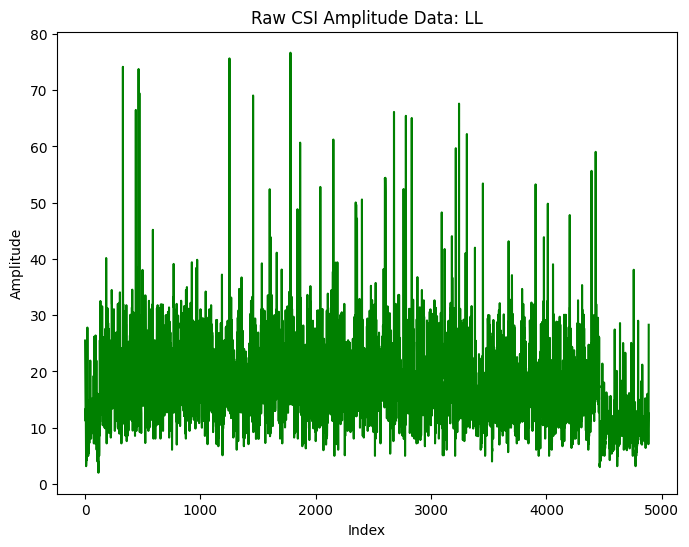

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(amp_dataframes[2][50],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title('Raw CSI Amplitude Data: LL')
plt.show()

In [40]:
print(amp_dataframes[2][50].head(10))

0    25.495098
1    23.194827
2    19.697716
3    15.620499
4    13.416408
5    11.180340
6    13.453624
7     9.433981
8     7.615773
9     3.162278
Name: 50, dtype: float64


## Apply noise filter

In [41]:
denoised_dataframes = []
for amplitude in amp_dataframes:
    filtered_data = pd.DataFrame()
    for col in amplitude.columns:
      col_series = amplitude[col]
      # Hampel filter

      hampel_filtered = hampel(col_series, window_size=10)
      # Savitzky-Golay filter
      sg_filtered = savgol_filter(hampel_filtered.filtered_data, window_length=10, polyorder=3)
      filtered_data[col] = sg_filtered
    denoised_dataframes.append(filtered_data)


In [42]:
print(len(denoised_dataframes))

42


In [43]:
path = '/content/ESP32-WiFi-Sensing/datasets/02-tvat-filtered'
for i, dataframe in enumerate(denoised_dataframes):
  filename = f"{label_list[i]}-{i+1}.csv"
  dataframe.to_csv(path+filename, index=False)


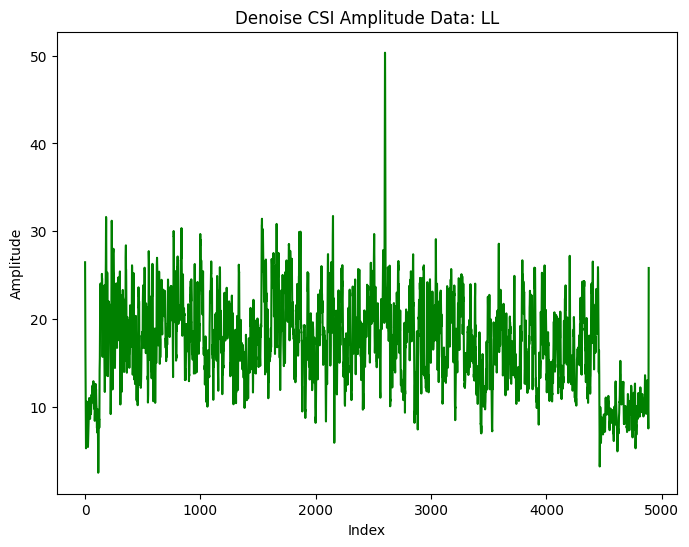

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(denoised_dataframes[2][50],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title('Denoise CSI Amplitude Data: LL')
plt.show()

In [45]:
print(denoised_dataframes[2][50].head(10))

0    26.481665
1    21.927896
2    18.604412
3    16.200443
4    14.405230
5    11.531882
6     9.614838
7     7.232495
8     5.302951
9     6.303108
Name: 50, dtype: float32


In [46]:

columns_to_drop = [2,3,4,5,32,59,60,61,62,63]
for df in amp_dataframes:
    df.drop(df.columns[columns_to_drop], axis=1,inplace=True)


## Segmentation

In [47]:
segment_dataframes = []
labels = []
for i, df in enumerate(amp_dataframes):
  df_len = len(df)
  #df['label'] = label_list[i]
  df.drop(df.columns[-1],axis=1,inplace=True)
  segment_len = (df_len//200)*200
  rows_to_skip = len(df) - segment_len
  rounded_df = df.iloc[rows_to_skip:]
  segment_df = np.array_split(rounded_df, range(200, len(rounded_df), 200))
  for segment in segment_df:
    segment_dataframes.append(segment)
    labels.append(label_list[i])


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.

In [48]:
print(len(segment_dataframes))
print(len(labels))

1378
1378


In [49]:
print(segment_dataframes[3])

            0    1          6          7          8          9          10  \
723  105.60303  4.0  28.425341  29.206164  29.000000  29.068884  27.202941   
724  105.60303  4.0  27.202941  27.202941  25.709920  29.120440  28.460499   
725  105.60303  4.0  27.294688  27.073973  30.265492  30.413813  29.427878   
726  105.60303  4.0  23.000000  28.071338  27.166155  25.079872  24.083189   
727  105.60303  4.0  24.698178  27.313001  24.351591  25.632011  25.000000   
..         ...  ...        ...        ...        ...        ...        ...   
918  105.60303  4.0  21.470911  24.738634  24.186773  25.961510  26.400758   
919  105.60303  4.0  64.938432  49.497475  60.827625  57.558666  63.198101   
920  105.60303  4.0  27.784888  27.730849  26.419690  25.238859  29.529646   
921  105.60303  4.0  25.806976  25.238859  23.600847  26.400758  23.853721   
922  105.60303  4.0  27.459060  24.758837  26.419690  24.083189  28.017851   

            11         12         13  ...         48         49

## CNN Model

In [50]:
# Convert DataFrames to matrices
matrix_list = [df.values for df in segment_dataframes]

# Stack matrices vertically
stacked_matrix = np.vstack(matrix_list)

In [51]:
dataset_array = np.concatenate(segment_dataframes, axis=0)

In [53]:
print(matrix_list.shape)

AttributeError: 'list' object has no attribute 'shape'

In [54]:
print(stacked_matrix)

[[105.60303026   4.          25.63201124 ...  15.23154621  13.92838828
   11.70469991]
 [105.60303026   4.           8.24621125 ...   4.           4.
    4.12310563]
 [105.60303026   4.          63.0634601  ...  54.4242593   49.65883607
   39.84971769]
 ...
 [105.60303026   4.          12.64911064 ...  12.08304597  14.76482306
   15.26433752]
 [105.60303026   4.           9.8488578  ...  13.41640786  13.03840481
   13.89244399]
 [105.60303026   4.           7.81024968 ...  11.40175425  11.40175425
   12.08304597]]


In [55]:
from sklearn.model_selection import train_test_split
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(segment_dataframes, labels, test_size=0.3, random_state=42)

X_train = np.array(X_train)
X_train = X_train.astype('float32')
X_train /= 255
X_test = np.array(X_test)
X_test = X_test.astype('float32')
X_test /= 255

In [56]:
print(X_train.shape)

(964, 200, 53)


In [57]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout,Attention
from tensorflow.keras.losses import SparseCategoricalCrossentropy


# Define the CNN model
model = keras.Sequential([
    keras.layers.Conv2D(32, 7, activation='relu' , input_shape=(200, 53,1)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(96, 5, activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(7, activation='softmax')

])

# Compile the model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 194, 47, 32)    │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 97, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 93, 19, 96)     │        76,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 46, 9, 96)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 39744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,087,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,174,567 (19.74 MB)

 Trainable params: 5,174,567 (19.74 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=8,validation_split=0.2)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 271ms/step - accuracy: 0.9613 - loss: 0.5518 - val_accuracy: 1.0000 - val_loss: 4.7189e-07
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 266ms/step - accuracy: 1.0000 - loss: 3.5568e-04 - val_accuracy: 1.0000 - val_loss: 1.9765e-08
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 273ms/step - accuracy: 1.0000 - loss: 7.5131e-05 - val_accuracy: 1.0000 - val_loss: 2.4707e-09
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 266ms/step - accuracy: 1.0000 - loss: 3.3611e-04 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 1.0000 - loss: 1.1660e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 271ms/step - accuracy: 1.0000 - loss: 1.7985e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 1.0000 - loss: 3.8307e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 262